In [1]:
from astropy.cosmology import WMAP9 as cosmo

In [2]:
(cosmo.comoving_distance(2.5) - cosmo.comoving_distance(2.4)).value

122.38303877464477

In [3]:
from astropy.cosmology import FlatLambdaCDM
CL = FlatLambdaCDM(H0=67, Om0=0.315, Ob0=0.049, Tcmb0=2.725)

In [4]:
(CL.comoving_volume(2.5) - CL.comoving_volume(1.74) ) / (((1/.67)*1000)**3)

<Quantity 121.33972458 Mpc3>

In [5]:
import healpy as hp
import numpy as np

In [6]:
###############################################################################
# These functions return the value of Omega_HI(z),b_HI and b_21cm for the model
def Omega_HI_model(z):
    return 4e-4*(1.0+z)**0.6

def HI_bias_model(z):
    return 0.904 + 0.135*(1.0+z)**1.696

def bias_21cm_model(z,Omega_m,Omega_L,h):
    Dz      = CL.linear_growth_factor(z,Omega_m,Omega_L)[0]
    HI_bias = HI_bias_model(z)
    mean_T  = 190.0*(1.0+z)**2/np.sqrt(Omega_m*(1.0+z)**3+Omega_L)*\
        Omega_HI_model(z)*h #mK
    b_21cm = Dz*mean_T*HI_bias
    return b_21cm
###############################################################################

###############################################################################
# This routine returns the dictionary survey that contains the parameters of
# the survey such as mean redshift, BoxSize, dims...etc
# bins_min,bins_max --------> consider maps between [bins_min,bins_max]
# nuTable ------------------> file with frequencies and redshifts of maps
# cosmo --------------------> dictionary with cosmological parameters
# instrument ---------------> dictionary with instrument parameters
def get_survey_params(bin_min,bin_max,nuTable,instrument,nu_skip=1):

    # compute value of dims for the 
    dims = bin_max - bin_min + 1

    # read the frequencies and redshifts of the maps
    num, nui, nuf, zi, zf = np.loadtxt(nuTable,unpack=True)

    # compute the comoving distance to the different maps
    # and volume
    d_co = np.zeros(len(num),dtype=np.float32);  z = 0.5*(zi+zf)
    v_co = np.zeros(len(num),dtype=np.float32);  z = 0.5*(zi+zf)
    for i in range(len(z)):
        d_co[i] = CL.comoving_distance(z[i]).value / .67  #Mpc/h
        v_co[i] = CL.comoving_volume(z[i]).value / (((1/.67)*1000)**3)  #Gpc^3 /h

    # for the maps selected compute BoxSize and mean distance among maps
    # notice that maps begin with 1, while z and d_co array begin with 0
    BoxSize = d_co[bin_min-1]-d_co[bin_max-1]  #Mpc/h
    coVolume = v_co[bin_min-1]-v_co[bin_max-1] #Mpc/h
    print('pixel separation = %.3f Mpc/h'%(BoxSize/dims))
    print('BoxSize =',BoxSize,'Mpc/h')
    print('comoving volume =',coVolume,'Gpc^3/h')
    # compute maps mean frequency, Bandwidth, wavelength and angular resolution
    nu_map     = 0.5*(nui+nuf)              #MHz
    Bnu_map    = nuf-nui                    #MHz
    lambda_map = 3e8/(nu_map*1e6)           #meters
    beam_fwhm  = lambda_map/instrument['D'] #radians

    # compute the mean redshift of the survey
    mean_z = 0.5*(z[bin_min-1]+z[bin_max-1]);  print('survey <z> = %.3f'%mean_z)

    survey = {'dims':dims,       'BoxSize':BoxSize,       'mean_z':mean_z,
              'Bnu_map':Bnu_map, 'lambda_map':lambda_map, 'beam_fwhm':beam_fwhm,
              'z_map':z,         'nu_map':nu_map, 'nu_skip':nu_skip}

    return survey

In [7]:
instrument = {"D": 15}
nuTable = './nuTable.txt'
survey = get_survey_params(1, 160, nuTable, instrument,nu_skip=5)

pixel separation = 11.069 Mpc/h
BoxSize = 1771.0771 Mpc/h
comoving volume = 162.13503 Gpc^3/h
survey <z> = 2.550


In [8]:
survey;

In [9]:
###############################################################################

###############################################################################
# This routine computes the expected noise level and variance from the 
# instrument temperature
# cosmo ------------------------> dictionary with cosmological parameters
# survey -----------------------> dictionary with survey parameters
# instrument -------------------> dictionary with instrument parameters
# z ----------------------------> mean redshift of the maps
# Tsystem ----------------------> system temperature at maps mean redshift
def noise_level_variance(cosmo,survey,instrument,z,Tsystem):

    # value of H(z) in km/s/(Mpc/h)
    Hz = 100.0*np.sqrt(cosmo['Omega_m']*(1.0+z)**3 + cosmo['Omega_L'])

    # mean brightness temperature at z in mK
    Tb = 190.0*(100.0*(1.0+z)**2/Hz)*Omega_HI_model(z)*cosmo['h']

    # compute noise level and variance in noise for auto-correlations
    noise_level = 0.5*0.21e-3*(1.0+z)**2/Hz*(Tsystem/Tb)**2/\
        (survey['t_pixel']*instrument['n_dish'])  #Mpc/h
    sigma_noise = noise_level/np.sqrt(survey['pixels'])
    survey['noise_level_auto'] = noise_level
    survey['sigma_noise_auto'] = sigma_noise

    # correct above numbers for cross-correlations. Total time is the same for
    # auto and cross-correlations
    sigma_noise /= np.sqrt(2.0)  #Mpc/h 
    noise_level = 0.0            #Mpc/h
    survey['noise_level_cross'] = noise_level
    survey['sigma_noise_cross'] = sigma_noise
###############################################################################

###############################################################################
# This routine computes the value of sigma_T for the 21cm IM pixels
# It returns arrays with the system temperature and sigma_T for the different 
# maps and the time per pixel
# cosmo ------------------> dictionary with cosmological parameters
# survey -----------------> dictionary with survey parameters
# instrument -------------> dictionary with instrument parameters
def sigmaT(survey,instrument):

    T_instrument = instrument['T_instrument']  #K
    n_dish       = instrument['n_dish']

    # compute the system temperature 
    T_sky    = 60*(survey['nu_map']/300.)**(-2.5) #Atmosphere temperature
    T_system = (T_instrument + T_sky)*1e3  #Total system temperature in mK

    # compute sigma_T. pixels is total number of pixels in whole sky. If survey
    # is covering a fraction fsky, the number of pixels surveyed is fsky*pixels
    t_pixel = survey['time_total']*3600.0/(survey['fsky']*survey['pixels']) #sec
    sigma_T = T_system/np.sqrt(2.0*survey['Bnu_map']*1e6*t_pixel*n_dish) #mK

    survey['T_system'] = T_system
    survey['t_pixel']  = t_pixel
    survey['sigma_T']  = sigma_T
###############################################################################

In [10]:
# survey characteristics
instrument['D']            = 15.0    #radio-telescope diameter in meters
instrument['T_instrument'] = 25.0    #K
survey['time_total']   = 10000.0 #hours
survey['fsky']         = 1.0    #sky fraction to be sampled
instrument['n_dish']       = 200     #number of antennae
instrument['nside']        = 64
instrument['mask']         = False
instrument['T_instrument'] = 25.0
instrument['n_dish'] = 25
instrument['time_total'] = 10000
#sigmaT(survey, instrument)

In [11]:
###############################################################################
# This routine computes the radial P(k) and xi(r) in each patch of the sky.
# The number of patchs on the sky is given by pixels/subpixels. This routine
# can be used to compute the mean P(k) and xi(r) in the whole sky and to 
# estimate the JK errors
# cosmo ------------------> dictionary with cosmological parameters
# survey -----------------> dictionary with survey parameters
# instrument -------------> dictionary with instrument parameters
# delta_k2 ---------------> structure with values of delta^2(k) for all los
def clustering_region(cosmo,survey,instrument,delta_k2,do_JK,subpixels=768):

    # read mask
    NPIX = hp.nside2npix(256)
    mask = np.ones(NPIX) #hp.read_map(fmask)

    dims = survey['dims'];  BoxSize   = survey['BoxSize']
    print('dims : ', dims)
    #subpixels = survey['subpixels'];  

    # compute the values of k and r of the modes for the 1D P(k) and xi(r)
    modes   = np.arange(dims,dtype=np.float64);  middle = dims/2
    indexes = np.where(modes>middle)[0];  modes[indexes] = modes[indexes]-dims
    k = modes*(2.0*np.pi/BoxSize)  #k in h/Mpc
    r = modes*(BoxSize*1.0/dims)   #r in Mpc/h
    k = np.absolute(k);  r = np.absolute(r)  #just take the modulus
    print('k length: ', k.shape)
    del indexes, modes

    # define the k-bins and r-bins
    k_bins = np.linspace(0,dims/2,dims//2+1)*(2.0*np.pi/BoxSize)
    print('k_bins length : ', k_bins.shape)
    r_bins = np.linspace(0,dims/2,dims//2+1)*(BoxSize*1.0/dims)

    # compute the number of modes and the average number-weighted value of k,r
    k_modes = np.histogram(k,bins=k_bins)[0]
    k_bin   = np.histogram(k,bins=k_bins,weights=k)[0]/k_modes
    r_modes = np.histogram(r,bins=r_bins)[0]
    r_bin   = np.histogram(r,bins=r_bins,weights=r)[0]/r_modes


    # compute P(k) over the lines of sight not masked out
    if do_JK==False:

        # find the lines of sight over which compute the radial P(k)
        indexes_los = np.where(mask==1.0)[0]
    
        ############################## Pk(k) ###############################
        # find the delta_k2 matrix of the region
        delta_k2_region = delta_k2[:,indexes_los]

        # take all LOS and compute the average value for each mode
        delta_k2_stacked = np.mean(delta_k2_region,dtype=np.float64,axis=1)

        # compute the 1D P(k)
        Pk_mean = np.histogram(k,bins=k_bins,weights=delta_k2_stacked)[0]
        Pk_mean = Pk_mean/(BoxSize*k_modes);  del delta_k2_stacked

        ############################## xi(r) ###############################
        # Fourier transform P(k) to obtain xi(r)
        xi = fftpack.fftn(delta_k2_region,overwrite_x=True,axes=(0,))
        del delta_k2_region

        # take all LOS and compute the average value for each mode
        xi_stacked = np.mean(xi,dtype=np.float64,axis=1);  del xi

        # compute the 1D xi(r)
        xi_mean = np.histogram(r,bins=r_bins,weights=xi_stacked)[0]
        xi_mean = xi_mean/r_modes;  del xi_stacked, indexes_los

        # no JK errors are computed here
        Pk_var = np.zeros(len(Pk_mean),dtype=np.float32)
        xi_var = np.zeros(len(xi_mean),dtype=np.float32)

        return [k_bin,r_bin,Pk_mean,xi_mean,Pk_var,xi_var]


    # compute the number of maps to estimate variance with jackknife
    regions = survey['pixels']/subpixels
    survey['regions'] = regions

    # for each region compute the 1D P(k) and xi(r)
    Pk_region = np.zeros((regions,len(k_modes)),dtype=np.float32)
    xi_region = np.zeros((regions,len(r_modes)),dtype=np.float32)
    for i in range(regions):

        print('Computing P_1D(k) and xi_1D(r) of region',i,'out of',regions)

        # find the indexes of the region
        indexes_region = np.arange(i*subpixels,(i+1)*subpixels)

        ############################## Pk(k) ###############################
        # find the delta_k2 matrix of the region
        delta_k2_region = delta_k2[:,indexes_region]

        # take all LOS and compute the average value for each mode
        delta_k2_stacked = np.mean(delta_k2_region,dtype=np.float64,axis=1)

        # compute the 1D P(k)
        Pk = np.histogram(k,bins=k_bins,weights=delta_k2_stacked)[0]
        Pk = Pk/(BoxSize*k_modes);  Pk_region[i] = Pk;  del delta_k2_stacked
        
        ############################## xi(r) ###############################
        # Fourier transform P(k) to obtain xi(r)
        xi = fftpack.fftn(delta_k2_region,overwrite_x=True,axes=(0,))
        del delta_k2_region

        # take all LOS and compute the average value for each mode
        xi_stacked = np.mean(xi,dtype=np.float64,axis=1);  del xi

        # compute the 1D xi(r)
        xi = np.histogram(r,bins=r_bins,weights=xi_stacked)[0]
        xi = xi/r_modes;  xi_region[i] = xi;  del xi_stacked
    del indexes_region

    # do a loop removing one region and compute P(k) and xi(r)
    Pk_jack = np.zeros((regions,len(k_modes)),dtype=np.float64)
    xi_jack = np.zeros((regions,len(r_modes)),dtype=np.float64)
    indexes = np.arange(regions)
    for i in range(regions):

        # find the indexes of all regions other than the deleted one
        indexes_to_consider = np.delete(indexes,i)

        # compute the average P(k) and xi(r) after removing the region
        Pk_jack[i] = np.mean(Pk_region[indexes_to_consider],axis=0)
        xi_jack[i] = np.mean(xi_region[indexes_to_consider],axis=0)

    # from all jackknife P(k) and xi(r) compute mean and variance
    Pk_mean = np.sum(Pk_jack,axis=0,dtype=np.float64)/regions
    xi_mean = np.sum(xi_jack,axis=0,dtype=np.float64)/regions

    Pk_var  = np.sqrt(np.sum((Pk_jack-Pk_mean)**2,axis=0,dtype=np.float64)*\
                          (regions-1.0)/regions)
    xi_var  = np.sqrt(np.sum((xi_jack-xi_mean)**2,axis=0,dtype=np.float64)*\
                          (regions-1.0)/regions)
    del Pk_jack, xi_jack, indexes

    return [k_bin,r_bin,Pk_mean,xi_mean,Pk_var,xi_var]

In [12]:
import matplotlib.pyplot as plt
from scipy import fftpack

In [13]:
###############################################################################
###############################################################################
# This routine reads the healpix maps by David Alonso and computes the
# radial 21cm P(k) and xi(r).
# root_map -----------------------> 
# nuTable ------------------------> file with frequencies and redshifts of maps
# D ------------------------------> diameter of the antenna in m
# n_dish -------------------------> number of antennae
# T_instrument -------------------> temperature of the antenna in K
# time_total ---------------------> total observing time in hours
# fsky ---------------------------> fraction of the sky observed 
# Omega_m ------------------------> value of Omega_m
# Omega_L ------------------------> value of Omega_l
# h ------------------------------> value of h
# n_side_map ---------------------> 
# subpixels ----------------------> 
# bin_min ------------------------> 
# bin_max ------------------------> 
# f_out --------------------------> 
def clustering_1D(root_map,nuTable,D,Omega_m,Omega_L,h,n_side_map,
                  bin_min,bin_max,T_instrument,time_total,fsky,n_dish,
                  do_JK,f_out, subpixels=768, nu_skip=1):

    # define cosmology dictionary
    cosmo = {'Omega_m':Omega_m, 'Omega_L':Omega_L, 'h':h}

    # define instrument dictionary
    instrument = {'D':D, 'n_dish':n_dish, 'T_instrument':T_instrument}

    # obtain some parameters of the survey
    survey = get_survey_params(bin_min,bin_max,nuTable,instrument,nu_skip=nu_skip)
    survey['time_total'] = time_total
    survey['fsky']       = fsky
    #survey['subpixels']  = subpixels
    dims1 = survey['dims'];  BoxSize = survey['BoxSize']

    # compute the growth factor at the mean redshift
    #Dz = CL.linear_growth_factor(survey['mean_z'],Omega_m,Omega_L);
    #cosmo['Dz'] = Dz;  print('D(<z>=%.3f) = %.3f'%(survey['mean_z'],Dz));  del Dz

    # define the data structure: create three structures for maps: one for maps
    # with no noise, and two for maps with noise for cross-correlations
    pixels = hp.nside2npix(n_side_map)  #number of pixels in a map with n_side
    delta1 = np.zeros((dims,pixels),dtype=np.float32) #no noise
    delta2 = np.zeros((dims,pixels),dtype=np.float32) #with noise
    delta3 = np.zeros((dims,pixels),dtype=np.float32) #with noise
    print('Number of pixels in the maps =',pixels,'\n')
    survey['pixels'] = pixels

    # compute T_system and sigma_T for each map and the time per pixel
    sigmaT(survey,instrument);  sigma_T = survey['sigma_T']  #mK

    
    # compute expected noise level and variance from system noise
    Tsystem_z = np.interp(survey['mean_z'],survey['z_map'][::-1],
                          survey['T_system'][::-1]) #mK
    noise_level_variance(cosmo,survey,instrument,survey['mean_z'],Tsystem_z)

    # read each map at i frequency and smooth them
    arr = np.arange(bin_min, bin_max+1)
    arr = arr[::survey['nu_skip']]

    # read each map at i frequency and smooth them
    for l in range(len(arr)):
        i = arr[l]
        # get map name and read it
        print('working with map:',i)
        f_map = root_map    + str(i).zfill(3) + '.fits';
        #map   = HP.read_map(f_map,nest=True,verbose=False)
        map   = hp.read_map(f_map,nest=False,verbose=False)
        map   = hp.smoothing(map,fwhm=survey['beam_fwhm'][i])
        map   = hp.reorder(map,r2n=True)  #change ordering from ring to nest
        map   = hp.ud_grade(map,nside_out=n_side_map,
                            order_in='NESTED',order_out='NESTED')

        # plot to make sure that submaps are coherent
        #for i in range(pixels//subpixels):
        #    map2 = np.copy(map);  map2[i*subpixels:(i+1)*subpixels] = 0 
        #    hp.mollview(map2,nest=True)
        #plt.show()

        # make three copies of the map: 1 without noise and 2 with noise
        # maps begin from 1, while sigma_T array begin from 0
        map1 = np.copy(map)                                                #mK
        map2 = np.copy(map);  map2 += sigma_T[i-1]*np.random.randn(pixels) #mK
        map3 = np.copy(map);  map3 += sigma_T[i-1]*np.random.randn(pixels) #mK

        # compute map mean temperature, find delta_T and fill data matrix
        mean_Tb1 = np.mean(map1,dtype=np.float64) #mK
        mean_Tb2 = np.mean(map2,dtype=np.float64) #mK
        mean_Tb3 = np.mean(map3,dtype=np.float64) #mK
        map1 = map1 - mean_Tb1;  delta1[i-bin_min] = map1
        map2 = map2 - mean_Tb2;  delta2[i-bin_min] = map2
        map3 = map3 - mean_Tb3;  delta3[i-bin_min] = map3
        print('z = %.3f ----> <Tb> = %.4f mK'%(survey['z_map'][i],mean_Tb1))
        print('%.3f < delta_T(%d) < %.3f\n'%(np.min(map1),i,np.max(map1)))
        del map1,map2,map3,map


    # Fourier transform only along the given axis
    print('\nFFT the overdensity field along axis 0')
    delta1_k = fftpack.fftn(delta1,overwrite_x=True,axes=(0,))
    delta1_k *= (BoxSize/dims);  del delta1

    delta2_k = fftpack.fftn(delta2,overwrite_x=True,axes=(0,))
    delta2_k *= (BoxSize/dims);  del delta2

    delta3_k = fftpack.ifftn(delta3,overwrite_x=True,axes=(0,))
    delta3_k *= BoxSize;         del delta3
    
    
    # compute delta^2(k) for auto-correlation w/o noise and for 
    # cross-correlation with noise
    delta2_k_auto  = np.absolute(delta1_k)**2;    del delta1_k
    delta2_k_cross = np.real(delta2_k*delta3_k);  del delta2_k,delta3_k

    # define suffix of output files
    suffix = '%d-%d_z=%.2f_D=%.0f_t=%.0f_nside=%d.dat'\
        %(bin_min,bin_max,survey['mean_z'],D,time_total,n_side_map)

    #################### auto-correlation ########################
    # compute mean P(k) and xi(r) and determine variance with JK
    [k_bin,r_bin,Pk_mean,xi_mean,Pk_var,xi_var] = \
        clustering_region(cosmo,survey,instrument,delta2_k_auto,do_JK)
    del delta2_k_auto

    # save results to file ignoring the DC mode
    f1 = f_out+'/Pk_new_cosmo_'+suffix;  f2 = f_out+'/xi_new_cosmo_'+suffix
    np.savetxt(f1,np.transpose([k_bin[1:],Pk_mean[1:],Pk_var[1:]]))
    np.savetxt(f2,np.transpose([r_bin[1:],xi_mean[1:],xi_var[1:]]))

    #################### cross-correlation #######################
    # compute mean P(k) and xi(r) and determine variance with JK
    [k_bin,r_bin,Pk_mean,xi_mean,Pk_var,xi_var] = \
        clustering_region(cosmo,survey,instrument,delta2_k_cross,do_JK)
    del delta2_k_cross

    # save results to file ignoring the DC mode
    f1 = f_out+'/Pk_new_noise_'+suffix;  f2 = f_out+'/xi_new_noise_'+suffix
    np.savetxt(f1,np.transpose([k_bin[1:],Pk_mean[1:],Pk_var[1:]]))
    np.savetxt(f2,np.transpose([r_bin[1:],xi_mean[1:],xi_var[1:]]))

    print('Noise level = %.3f Mpc/h'%survey['noise_level_cross'])
    print('sigma noise = %.3e Mpc/h'%survey['sigma_noise_cross'])
###############################################################################
###############################################################################


In [14]:
###############################################################################
###############################################################################
# This routine reads the healpix maps by David Alonso and computes the
# radial 21cm P(k) and xi(r).
# root_map -----------------------> 
# nuTable ------------------------> file with frequencies and redshifts of maps
# D ------------------------------> diameter of the antenna in m
# n_dish -------------------------> number of antennae
# T_instrument -------------------> temperature of the antenna in K
# time_total ---------------------> total observing time in hours
# fsky ---------------------------> fraction of the sky observed 
# Omega_m ------------------------> value of Omega_m
# Omega_L ------------------------> value of Omega_l
# h ------------------------------> value of h
# n_side_map ---------------------> 
# subpixels ----------------------> 
# bin_min ------------------------> 
# bin_max ------------------------> 
# f_out --------------------------> 
def clustering_1D_np(input_map,nuTable,D,Omega_m,Omega_L,h,n_side_map,
                  bin_min,bin_max,T_instrument,time_total,fsky,n_dish,
                  do_JK,f_out, f_out2, subpixels=768, nu_skip=1):

    # define cosmology dictionary
    cosmo = {'Omega_m':Omega_m, 'Omega_L':Omega_L, 'h':h}

    # define instrument dictionary
    instrument = {'D':D, 'n_dish':n_dish, 'T_instrument':T_instrument}

    # obtain some parameters of the survey
    survey = get_survey_params(bin_min,bin_max,nuTable,instrument,nu_skip=nu_skip)
    survey['time_total'] = time_total
    survey['fsky']       = fsky
    #survey['nu_skip']    = nu_skip
    #survey['subpixels']  = subpixels
    dims = survey['dims'];  BoxSize = survey['BoxSize']; dims1 = (bin_max - bin_min + 1)
    rearr = np.load('rearr_nside8.npy')
    nu_arr = np.arange(1, 32*5, 5)
    # compute the growth factor at the mean redshift
    #Dz = CL.linear_growth_factor(survey['mean_z'],Omega_m,Omega_L);
    #cosmo['Dz'] = Dz;  print('D(<z>=%.3f) = %.3f'%(survey['mean_z'],Dz));  del Dz

    # define the data structure: create three structures for maps: one for maps
    # with no noise, and two for maps with noise for cross-correlations
    pixels = hp.nside2npix(n_side_map)  #number of pixels in a map with n_side
    delta1 = np.zeros((dims1,pixels),dtype=np.float32) #no noise
    delta2 = np.zeros((dims1,pixels),dtype=np.float32) #with noise
    delta3 = np.zeros((dims1,pixels),dtype=np.float32) #with noise
    print('Number of pixels in the maps =',pixels,'\n')
    print('delta dims: ', delta1.shape)
    survey['pixels'] = pixels

    # compute T_system and sigma_T for each map and the time per pixel
    sigmaT(survey,instrument);  sigma_T = survey['sigma_T']  #mK

    
    # compute expected noise level and variance from system noise
    Tsystem_z = np.interp(survey['mean_z'],survey['z_map'][::-1],
                          survey['T_system'][::-1]) #mK
    noise_level_variance(cosmo,survey,instrument,survey['mean_z'],Tsystem_z)


    # read each map at i frequency and smooth them
    arr = np.arange(bin_min, bin_max+1)
    arr = arr[::survey['nu_skip']]
    #arr = np.array([np.mean(i,axis=0) for i in np.split(arr,((bin_max+1 - bin_min) // survey['nu_skip']))]).astype(int)


    #for i in range(bin_min, bin_max+1):
    for l in range(len(arr)):
        i = arr[l]
        #i = l
        # get map name and read it
        print('working with map:',i)
        #f_map = root_map    + str(i).zfill(3) + '.fits';
        #map   = HP.read_map(f_map,nest=True,verbose=False)
        #map   = hp.read_map(f_map,nest=False,verbose=False)
        map   = input_map.T[l].T.flatten()[rearr]
        map   = hp.smoothing(map,fwhm=survey['beam_fwhm'][i])
        map   = hp.reorder(map,r2n=True)  #change ordering from ring to nest
        map   = hp.ud_grade(map,nside_out=n_side_map,
                            order_in='NESTED',order_out='NESTED')

        # plot to make sure that submaps are coherent
        #for i in range(pixels//subpixels):
        #    map2 = np.copy(map);  map2[i*subpixels:(i+1)*subpixels] = 0 
        #    hp.mollview(map2,nest=True)
        #plt.show()

        # make three copies of the map: 1 without noise and 2 with noise
        # maps begin from 1, while sigma_T array begin from 0
        map1 = np.copy(map)                                                #mK
        map2 = np.copy(map);  map2 += sigma_T[i-1]*np.random.randn(pixels) #mK
        map3 = np.copy(map);  map3 += sigma_T[i-1]*np.random.randn(pixels) #mK

        # compute map mean temperature, find delta_T and fill data matrix
        mean_Tb1 = np.mean(map1,dtype=np.float64) #mK
        mean_Tb2 = np.mean(map2,dtype=np.float64) #mK
        mean_Tb3 = np.mean(map3,dtype=np.float64) #mK
#         map1 = map1 - mean_Tb1;  delta1[i-bin_min] = map1
#         map2 = map2 - mean_Tb2;  delta2[i-bin_min] = map2
#         map3 = map3 - mean_Tb3;  delta3[i-bin_min] = map3
        map1 = map1 - mean_Tb1;  delta1[i-bin_min:i-bin_min+survey['nu_skip']] = np.array([map1]*survey['nu_skip'])
        map2 = map2 - mean_Tb2;  delta2[i-bin_min:i-bin_min+survey['nu_skip']] = np.array([map2]*survey['nu_skip'])
        map3 = map3 - mean_Tb3;  delta3[i-bin_min:i-bin_min+survey['nu_skip']] = np.array([map3]*survey['nu_skip'])
        print('z = %.3f ----> <Tb> = %.4f mK'%(survey['z_map'][i],mean_Tb1))
        print('%.3f < delta_T(%d) < %.3f\n'%(np.min(map1),i,np.max(map1)))
        del map1,map2,map3


    # Fourier transform only along the given axis
    print('\nFFT the overdensity field along axis 0')
    delta1_k = fftpack.fftn(delta1,overwrite_x=True,axes=(0,))
    delta1_k *= (BoxSize/dims1);  del delta1

    delta2_k = fftpack.fftn(delta2,overwrite_x=True,axes=(0,))
    delta2_k *= (BoxSize/dims1);  del delta2

    delta3_k = fftpack.ifftn(delta3,overwrite_x=True,axes=(0,))
    delta3_k *= BoxSize;         del delta3
    
    
    # compute delta^2(k) for auto-correlation w/o noise and for 
    # cross-correlation with noise
    delta2_k_auto  = np.absolute(delta1_k)**2;    del delta1_k
    delta2_k_cross = np.real(delta2_k*delta3_k);  del delta2_k,delta3_k

    # define suffix of output files
    suffix = '%d-%d_z=%.2f_D=%.0f_t=%.0f_nside=%d.dat'\
        %(bin_min,bin_max,survey['mean_z'],D,time_total,n_side_map)

    #################### auto-correlation ########################
    # compute mean P(k) and xi(r) and determine variance with JK
    [k_bin,r_bin,Pk_mean,xi_mean,Pk_var,xi_var] = \
        clustering_region(cosmo,survey,instrument,delta2_k_auto,do_JK)
    del delta2_k_auto

    # save results to file ignoring the DC mode
    f1 = f_out+'/'+f_out2+'Pk_new_cosmo_'+suffix;  f2 = f_out+'/'+f_out2+'xi_new_cosmo_'+suffix
    np.savetxt(f1,np.transpose([k_bin[1:],Pk_mean[1:],Pk_var[1:]]))
    np.savetxt(f2,np.transpose([r_bin[1:],xi_mean[1:],xi_var[1:]]))

    #################### cross-correlation #######################
    # compute mean P(k) and xi(r) and determine variance with JK
    [k_bin,r_bin,Pk_mean,xi_mean,Pk_var,xi_var] = \
        clustering_region(cosmo,survey,instrument,delta2_k_cross,do_JK)
    del delta2_k_cross

    # save results to file ignoring the DC mode
    f1 = f_out+'/'+f_out2+'Pk_new_noise_'+suffix;  f2 = f_out+'/'+f_out2+'xi_new_noise_'+suffix
    np.savetxt(f1,np.transpose([k_bin[1:],Pk_mean[1:],Pk_var[1:]]))
    np.savetxt(f2,np.transpose([r_bin[1:],xi_mean[1:],xi_var[1:]]))

    print('Noise level = %.3f Mpc/h'%survey['noise_level_cross'])
    print('sigma noise = %.3e Mpc/h'%survey['sigma_noise_cross'])
###############################################################################
###############################################################################


In [28]:
root_map = '/mnt/home/tmakinen/ceph/ska2/sim_92/cosmo/cosmo_'
clustering_1D(root_map,nuTable,D,Omega_m,Omega_L,h,n_side_map,
                  bin_min,bin_max,T_instrument,time_total,fsky,n_dish,
                  do_JK,f_out, subpixels=768, nu_skip=1)

pixel separation = 11.069 Mpc/h
BoxSize = 1771.0771 Mpc/h
comoving volume = 162.13503 Gpc^3/h
survey <z> = 2.550
Number of pixels in the maps = 786432 

working with map: 1


/mnt/home/tmakinen/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Sigma is 83.182102 arcmin (0.024197 rad) 
-> fwhm is 195.878880 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 3.047 ----> <Tb> = 0.7150 mK
-0.105 < delta_T(1) < 0.124

working with map: 2
Sigma is 83.023055 arcmin (0.024150 rad) 
-> fwhm is 195.504355 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 3.039 ----> <Tb> = 0.7125 mK
-0.105 < delta_T(2) < 0.122

working with map: 3
Sigma is 82.864451 arcmin (0.024104 rad) 
-> fwhm is 195.130869 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 3.031 ----> <Tb> = 0.7104 mK
-0.103 < delta_T(3) < 0.111

working with map: 4
Sigma is 82.706284 arcmin (0.024058 rad) 
-> fwhm is 194.758416 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 3.024 ----> <Tb> = 0.7084 mK
-0.108 < delta_T(4) < 0.115

working with map: 5
Sigma is 82.548556 arcmin (0.024012 rad) 
-> fwhm is 194.386994 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> f

KeyboardInterrupt: 

In [15]:
# survey characteristics
D            = 15.0    #radio-telescope diameter in meters
T_instrument = 25.0    #K
time_total   = 10000.0 #hours
fsky         = 0.58    #sky fraction to be sampled
n_dish       = 200     #number of antennae
nside        = 64
mask         = True

# for clustering function
root_map = '/mnt/home/tmakinen/ceph/ska2/sim_1/cosmo/cosmo_'
Omega_m = 0.315
Omega_L = 1 - 0.315
h = 0.67
n_side_map = 256
bin_min = 1
bin_max = 160
T_instrument = 25
time_total = 10000
fsky = 1.0
n_dish = 254
do_JK = False
f_out = './radial_pka/'

In [32]:
cosmo_mid = np.load('cosmo_467_605.npy')
clustering_1D_np(cosmo_mid,nuTable,D,Omega_m,Omega_L,h,n_side_map,
                 161,320,T_instrument,time_total,fsky,n_dish,
                 do_JK,f_out,f_out2='cosmo_mid', subpixels=768, nu_skip=5)

pixel separation = 11.071 Mpc/h
BoxSize = 1771.3306 Mpc/h
comoving volume = 104.24703 Gpc^3/h
survey <z> = 1.696
Number of pixels in the maps = 786432 

delta dims:  (160, 786432)
working with map: 161
Sigma is 62.394400 arcmin (0.018150 rad) 
-> fwhm is 146.927584 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 2.035 ----> <Tb> = 0.7150 mK
-0.139 < delta_T(161) < 0.177

working with map: 166
Sigma is 61.869028 arcmin (0.017997 rad) 
-> fwhm is 145.690428 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 2.010 ----> <Tb> = 0.7037 mK
-0.117 < delta_T(166) < 0.150

working with map: 171
Sigma is 61.349782 arcmin (0.017846 rad) 
-> fwhm is 144.467697 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 1.985 ----> <Tb> = 0.6929 mK
-0.136 < delta_T(171) < 0.157

working with map: 176
Sigma is 60.836558 arcmin (0.017697 rad) 
-> fwhm is 143.259147 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 

In [83]:
nn_pred_old = np.squeeze(np.load('generalization_comp/nn_preds_avg_old.npy'))#np.squeeze(np.load('./generalization_comp/nn_preds_avg_new.npy'))
cosmo_old = np.squeeze(np.load('/mnt/home/tmakinen/ceph/pca_ska/avg/test/cosmo_sim091.npy'))


nn_pred_new = np.squeeze(np.load('./generalization_comp/nn_preds_avg_new.npy'))
cosmo_new = np.squeeze(np.load('/mnt/home/tmakinen/ceph/pca_ska/avg/test_new_params/cosmo_sim001.npy'))

clustering_1D_np(nn_pred_old[3],nuTable,D,Omega_m,Omega_L,h,n_side_map,
                  bin_min,bin_max,T_instrument,time_total,fsky,n_dish,
                  do_JK,f_out,f_out2='nn_old', subpixels=768, nu_skip=5)

#res_map = np.load('./interp_preds_1_161.npy') - np.load('./cosmo_true_1_161.npy')
clustering_1D_np(cosmo_old,nuTable,D,Omega_m,Omega_L,h,n_side_map,
                 bin_min,bin_max,T_instrument,time_total,fsky,n_dish,
                 do_JK,f_out,f_out2='cosmo_old', subpixels=768, nu_skip=5)

clustering_1D_np(nn_pred_new[3],nuTable,D,Omega_m,Omega_L,h,n_side_map,
                  bin_min,bin_max,T_instrument,time_total,fsky,n_dish,
                  do_JK,f_out,f_out2='nn_new', subpixels=768, nu_skip=5)

#res_map = np.load('./interp_preds_1_161.npy') - np.load('./cosmo_true_1_161.npy')
clustering_1D_np(cosmo_new,nuTable,D,Omega_m,Omega_L,h,n_side_map,
                 bin_min,bin_max,T_instrument,time_total,fsky,n_dish,
                 do_JK,f_out,f_out2='cosmo_new', subpixels=768, nu_skip=5)

pixel separation = 11.069 Mpc/h
BoxSize = 1771.0771 Mpc/h
comoving volume = 162.13503 Gpc^3/h
survey <z> = 2.550
Number of pixels in the maps = 786432 

delta dims:  (160, 786432)
working with map: 1
Sigma is 83.182102 arcmin (0.024197 rad) 
-> fwhm is 195.878880 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 3.047 ----> <Tb> = 0.7167 mK
-0.066 < delta_T(1) < 0.102

working with map: 6
Sigma is 82.391264 arcmin (0.023967 rad) 
-> fwhm is 194.016600 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 3.008 ----> <Tb> = 0.7078 mK
-0.077 < delta_T(6) < 0.094

working with map: 11
Sigma is 81.611290 arcmin (0.023740 rad) 
-> fwhm is 192.179903 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 2.970 ----> <Tb> = 0.6979 mK
-0.091 < delta_T(11) < 0.099

working with map: 16
Sigma is 80.841976 arcmin (0.023516 rad) 
-> fwhm is 190.368306 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 ar

/mnt/home/tmakinen/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/numpy/core/_methods.py:151: ComplexWarning: Casting complex values to real discards the imaginary part
  ret = umr_sum(arr, axis, dtype, out, keepdims)


dims :  160
k length:  (160,)
k_bins length :  (81,)
Noise level = 0.000 Mpc/h
sigma noise = 5.442e-03 Mpc/h
pixel separation = 11.069 Mpc/h
BoxSize = 1771.0771 Mpc/h
comoving volume = 162.13503 Gpc^3/h
survey <z> = 2.550
Number of pixels in the maps = 786432 

delta dims:  (160, 786432)
working with map: 1
Sigma is 83.182102 arcmin (0.024197 rad) 
-> fwhm is 195.878880 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 3.047 ----> <Tb> = 0.7141 mK
-0.089 < delta_T(1) < 0.122

working with map: 6
Sigma is 82.391264 arcmin (0.023967 rad) 
-> fwhm is 194.016600 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 3.008 ----> <Tb> = 0.7040 mK
-0.106 < delta_T(6) < 0.138

working with map: 11
Sigma is 81.611290 arcmin (0.023740 rad) 
-> fwhm is 192.179903 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
z = 2.970 ----> <Tb> = 0.6932 mK
-0.101 < delta_T(11) < 0.118

working with map: 16
Sigma is 80.841976 arcmin

In [16]:
k3Dw, Pk3Dw_nn_old, _  = np.loadtxt('./radial_pka/nn_oldPk_new_cosmo_1-160_z=2.55_D=15_t=10000_nside=256.dat', unpack=True)
k3Dw, Pk3Dw_old, _  = np.loadtxt('./radial_pka/cosmo_oldPk_new_cosmo_1-160_z=2.55_D=15_t=10000_nside=256.dat', unpack=True)

k3Dw, Pk3Dw_nn_new, _  = np.loadtxt('./radial_pka/nn_newPk_new_cosmo_1-160_z=2.55_D=15_t=10000_nside=256.dat', unpack=True)
k3Dw, Pk3Dw_new, _  = np.loadtxt('./radial_pka/cosmo_newPk_new_cosmo_1-160_z=2.55_D=15_t=10000_nside=256.dat', unpack=True)

In [33]:
k3Dw, Pk3Dw_mid, _  = np.loadtxt('./radial_pka/cosmo_midPk_new_cosmo_161-320_z=1.70_D=15_t=10000_nside=256.dat', unpack=True)

In [17]:
k3Dw, Pk3Dw_res, _  = np.loadtxt('Pk_new_cosmo_1-160_z=2.55_D=15_t=10000_nside=256.dat', unpack=True)

In [18]:
# the integrand in the calculation of mu from z,cosmology
import scipy.integrate as si
import math
import scipy.constants as cnst
def integrand(zba, omegam, omegade):
    w = 1.0
    return 1.0/np.sqrt(
        omegam*(1+zba)**3 + omegade*(1+zba)**(3.+3.*w) + (1.-omegam-omegade)*(1.+zba)**2
    )

# integration of the integrand given above
def hubble(z,omegam, omegade):
    w = 1.0
    # if an iterable of z's was given then use the spline
    # method for calculating the integral
    I = si.quad(integrand,0., z,args = (omegam,omegade))[0]
    return I

# Dlz
# N.B. z is z_CMB
def Dlz(omegam, omegade, z):
    h = 0.67
    z_helio = z
    hubbleint = hubble(z,omegam,omegade)
    omegakmag =  np.sqrt(np.abs(1-omegam-omegade))
    if (omegam+omegade)>1:
        distance = (cnst.c*1e-5 *(1+z_helio)/(h*omegakmag)) *np.sin(hubbleint*omegakmag)
    elif (omegam+omegade)==1:
        distance = cnst.c*1e-5 *(1+z_helio)* hubbleint/h
    else:
        distance = cnst.c*1e-5 *(1+z_helio)/(h*omegakmag) *np.sinh(hubbleint*omegakmag)
    return distance

In [19]:
# These functions return the value of Omega_HI(z),b_HI and b_21cm for the model
def Omega_HI_model(z):
    return 4e-4*(1.0+z)**0.6

def HI_bias_model(z):
    return 0.904 + 0.135*(1.0+z)**1.696

def bias_21cm_model(z,Omega_m,Omega_L,h):
    Dz      = Dlz(Omega_m,Omega_L,z)
    HI_bias = HI_bias_model(z)
    mean_T  = 190.0*(1.0+z)**2/np.sqrt(Omega_m*(1.0+z)**3+Omega_L)*\
        Omega_HI_model(z)*h #mK
    b_21cm = Dz*mean_T*HI_bias
    return b_21cm

In [20]:
Dlz(Omega_m,Omega_L,2.55)

8103.497741917215

In [21]:
# compute the HI bias and Tb at <z>
mean_z = 2.55
Omega_HI = Omega_HI_model(mean_z)
b_HI     = HI_bias_model(mean_z)                     #HI bias
b_21     = bias_21cm_model(mean_z,Omega_m,Omega_L,h) #21cm bias

# compute the redshift-space distortion parameters beta
Omega_mz = Omega_m*(1.0+mean_z)**3/(Omega_m*(1.0+mean_z)**3+Omega_L)
beta     = 1 #Omega_mz**0.54545454/b_HI

In [22]:
# compute P_1D(k) = \int_0^oo k_perp P_3D(k_par,k_perp) e^(-k_perp^2R^2) dk_perp
def Pk_1D_integrand(y,x,k,Pk,k_par,beta,R):
    k_mod     = math.sqrt(k_par**2 + x**2)
    Pk_interp = np.interp(np.log(k_mod),np.log(k),Pk)
    aux       = math.exp(-(x*R)**2 - 4.0*k_mod**2)
    #aux       = math.exp(-(x*R)**2)
    return Pk_interp*x*(1.0+beta*(k_par/k_mod)**2)**2*aux

# This function computes the 1D P(k) within [kmin,kmax] from the 3D one 
# taking into account the value of beta and R
def Pk_1D_model(kmin,kmax,bins_1D,k,Pk,beta,R):
    k_1D  = np.logspace(np.log10(kmin),np.log10(kmax),bins_1D)
    Pk_1D = np.zeros(bins_1D,dtype=np.float64)
    for i,k_par in enumerate(k_1D):
        yinit = [0.0];  k_limits = [0.0,np.sqrt(k[-1]**2-k_par**2)]
        Pk_1D[i] = si.odeint(Pk_1D_integrand,yinit,k_limits,
                             args=(k,Pk,k_par,beta,R),
                             mxstep=100000,rtol=1e-10,atol=1e-12,
                             h0=1e-10)[1][0]/(2*np.pi)
    return [k_1D,Pk_1D]

In [23]:
pk_cosmo_old = np.array(Pk_1D_model(0.01, 0.2, 200, (k3Dw), (Pk3Dw_old), beta, 0))
pk_pred_old = np.array(Pk_1D_model(0.01, 0.2, 200, (k3Dw), (Pk3Dw_nn_old), beta, 0))

pk_cosmo_new = np.array(Pk_1D_model(0.01, 0.2, 200, (k3Dw), (Pk3Dw_new), beta, 0))
pk_pred_new = np.array(Pk_1D_model(0.01, 0.2, 200, (k3Dw), (Pk3Dw_nn_new), beta, 0))

In [85]:
pk_cosmo_mid = np.array(Pk_1D_model(0.02, 0.21, 25, (k3Dw), (Pk3Dw_mid), 0.01, 0))

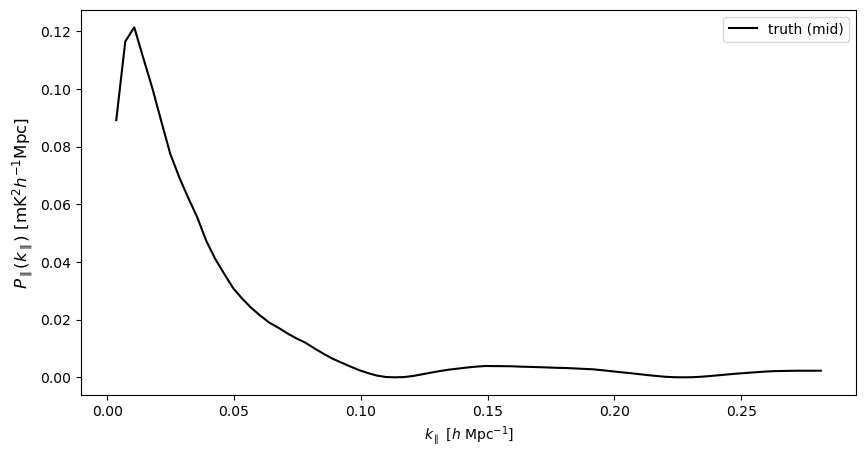

In [36]:
plt.style.use('default')
plt.figure(figsize=(10, 5))
plt.plot(k3Dw, Pk3Dw_mid, c='k', label='truth (mid)')
#plt.plot(k3Dw, Pk3Dw_nn_old, label='nn prediction (old)')

#plt.plot(k3Dw, Pk3Dw_new, c='k', linestyle='--', label='truth (new)')
#plt.plot(k3Dw, Pk3Dw_nn_new, linestyle='--', label='nn prediction (new)')
#plt.plot(pk_cosmo[0], pk_pred[1])
#plt.plot(pk_pca[0], pk_pca[1])
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r'$P_\parallel(k_\parallel)\ [{\rm mK}^2 h^{-1} {\rm Mpc}]$', fontsize=12)
plt.xlabel(r'$k_\parallel\ [h\ \rm Mpc^{-1}]$')
plt.legend()

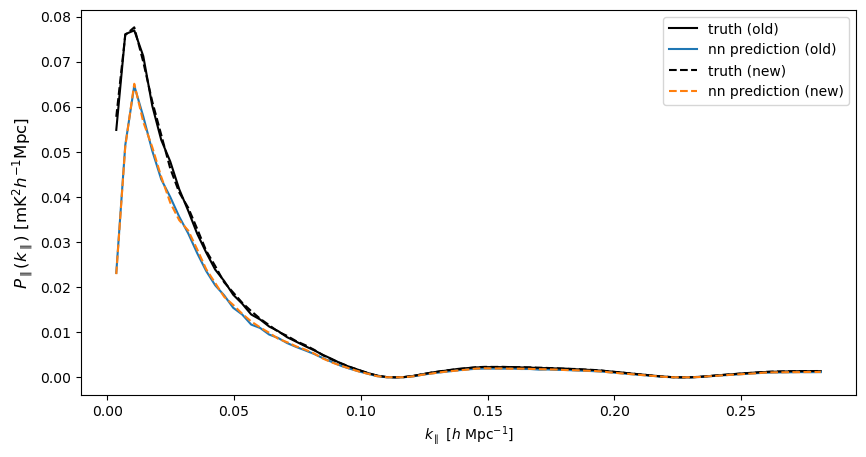

In [24]:
plt.style.use('default')
plt.figure(figsize=(10, 5))
plt.plot(k3Dw, Pk3Dw_old, c='k', label='truth (old)')
plt.plot(k3Dw, Pk3Dw_nn_old, label='nn prediction (old)')

plt.plot(k3Dw, Pk3Dw_new, c='k', linestyle='--', label='truth (new)')
plt.plot(k3Dw, Pk3Dw_nn_new, linestyle='--', label='nn prediction (new)')
#plt.plot(pk_cosmo[0], pk_pred[1])
#plt.plot(pk_pca[0], pk_pca[1])
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r'$P_\parallel(k_\parallel)\ [{\rm mK}^2 h^{-1} {\rm Mpc}]$', fontsize=12)
plt.xlabel(r'$k_\parallel\ [h\ \rm Mpc^{-1}]$')
plt.legend()

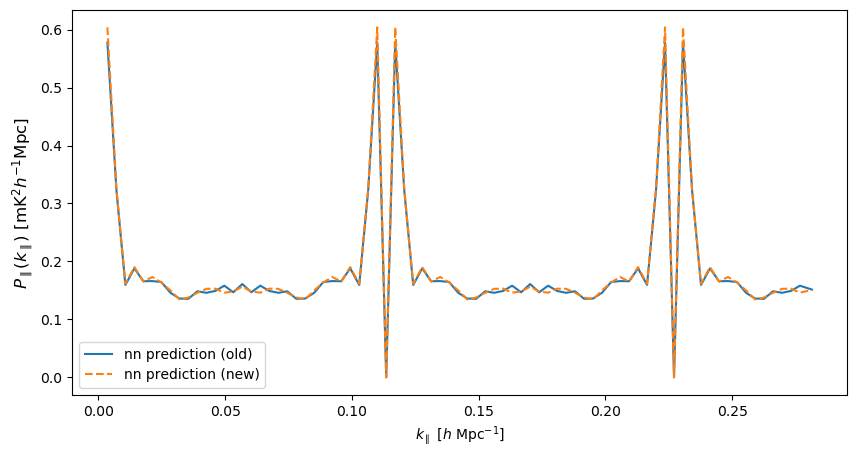

In [27]:
plt.style.use('default')
plt.figure(figsize=(10, 5))
#plt.plot(k3Dw, Pk3Dw_old, c='k', label='truth (old)')

zero_indx = np.where(Pk3Dw_old <= 0)[0]
pk_old = Pk3Dw_old.copy()
pk_old[zero_indx] = 1
plt.plot(k3Dw, np.abs(Pk3Dw_nn_old-Pk3Dw_old) / pk_old, label='nn prediction (old)')


zero_indx = np.where(Pk3Dw_new <= 0)[0]
pk_new = Pk3Dw_new.copy()
pk_new[zero_indx] = 1
#plt.plot(k3Dw, Pk3Dw_new, c='k', linestyle='--', label='truth (new)')
plt.plot(k3Dw, (np.abs(Pk3Dw_nn_new-Pk3Dw_new) / pk_new), linestyle='--', label='nn prediction (new)')
#plt.plot(pk_cosmo[0], pk_pred[1])
#plt.plot(pk_pca[0], pk_pca[1])
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r'$P_\parallel(k_\parallel)\ [{\rm mK}^2 h^{-1} {\rm Mpc}]$', fontsize=12)
plt.xlabel(r'$k_\parallel\ [h\ \rm Mpc^{-1}]$')
plt.legend()

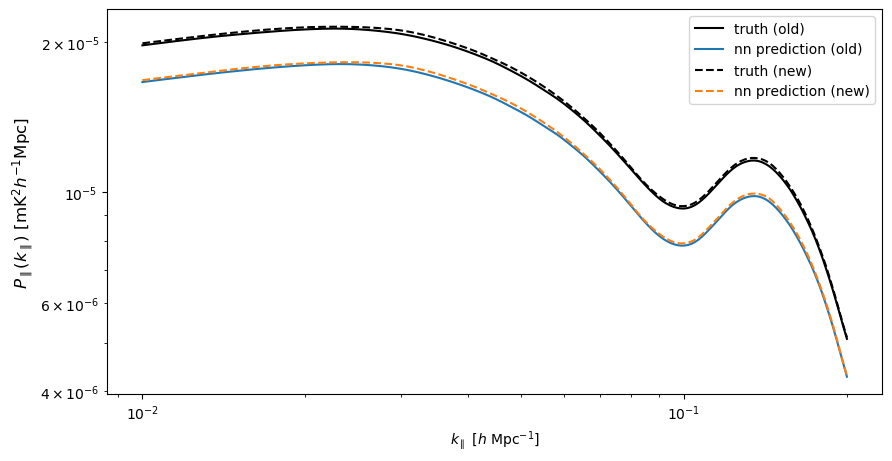

In [95]:
plt.style.use('default')
plt.figure(figsize=(10, 5))
plt.plot(pk_cosmo_old[0], pk_cosmo_old[1], c='k', label='truth (old)')
plt.plot(pk_pred_old[0], np.abs(pk_pred_old[1] ), label='nn prediction (old)')

plt.plot(pk_cosmo_new[0], pk_cosmo_new[1], c='k', linestyle='--', label='truth (new)')
plt.plot(pk_pred_new[0], np.abs(pk_pred_new[1]), linestyle='--', label='nn prediction (new)')
#plt.plot(pk_cosmo[0], pk_pred[1])
#plt.plot(pk_pca[0], pk_pca[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$P_\parallel(k_\parallel)\ [{\rm mK}^2 h^{-1} {\rm Mpc}]$', fontsize=12)
plt.xlabel(r'$k_\parallel\ [h\ \rm Mpc^{-1}]$')
plt.legend()

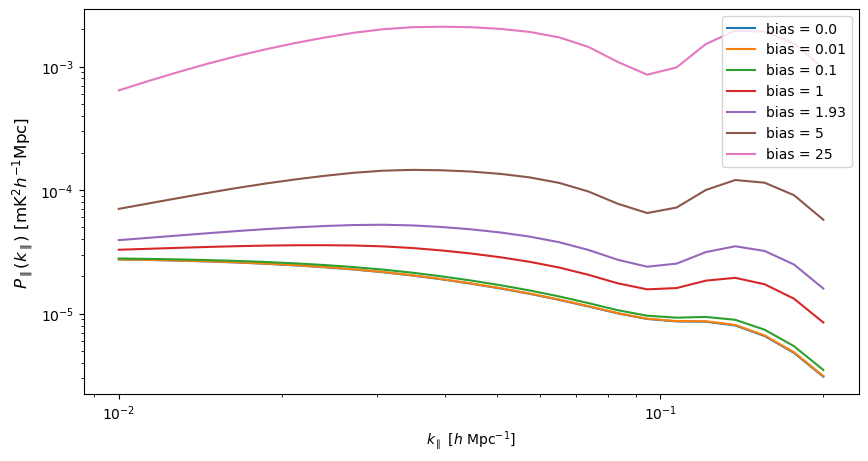

In [106]:
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plt.style.use('default')
plt.figure(figsize=(10, 5))
for b,beta in enumerate([0., 0.01, 0.1, 1, 1.93, 5, 25]):
    #for r,R in enumerate([0, 5, 10, 25]):

    pk_cosmo_mid = np.array(Pk_1D_model(0.01, 0.2, 25, (k3Dw), (Pk3Dw_mid), beta, 0))


    plt.plot(pk_cosmo_mid[0], pk_cosmo_mid[1], c=colors[b], label='bias = {}'.format(beta))
    #plt.plot(pk_pred_old[0], np.abs(pk_pred_old[1] ), label='nn prediction (old)')

    #plt.plot(pk_cosmo_new[0], pk_cosmo_new[1], c='k', linestyle='--', label='truth (new)')
    #plt.plot(pk_pred_new[0], np.abs(pk_pred_new[1]), linestyle='--', label='nn prediction (new)')
    #plt.plot(pk_cosmo[0], pk_pred[1])
    #plt.plot(pk_pca[0], pk_pca[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$P_\parallel(k_\parallel)\ [{\rm mK}^2 h^{-1} {\rm Mpc}]$', fontsize=12)
plt.xlabel(r'$k_\parallel\ [h\ \rm Mpc^{-1}]$')
plt.legend()